In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

import sklearn.model_selection

Table of contents
1. Import data
2. Extract year
3. Missing values
4. Categorical value cardinality
5. Investigate price - distribution, removal of values
6. Investigate individual features - correlation, unique values

## Import Data

In [4]:
# Read CSV and drop index column
data = pd.read_csv('data/winemag-data-130k-v2.csv')
data.sample(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
47138,47138,Bulgaria,"Pale straw in the glass, this wine has a nose ...",Collection,91,23.0,Danube River Plains,NaN,NaN,Jeff Jenssen,@worldwineguys,Chateau Burgozone 2012 Collection Chardonnay (...,Chardonnay,Chateau Burgozone
8964,8964,US,"This is a big, rich, somewhat heavy Pinot Noir...",NaN,89,55.0,California,Sonoma Mountain,Sonoma,NaN,NaN,Aiken 2010 Pinot Noir (Sonoma Mountain),Pinot Noir,Aiken
109564,109564,France,"Dry and tannic, this totally structured wine h...",Tradition,85,60.0,Bordeaux,Bordeaux Supérieur,NaN,Roger Voss,@vossroger,Château Thuron 2005 Tradition (Bordeaux Supér...,Bordeaux-style Red Blend,Château Thuron
109079,109079,US,Fruit fans will exult in this jammy Pinot Noir...,NaN,87,38.0,California,Russian River Valley,Sonoma,NaN,NaN,Ketcham Estate 2008 Pinot Noir (Russian River ...,Pinot Noir,Ketcham Estate
105245,105245,US,"This wine boasts a lovely, creamy texture and ...",NaN,90,17.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Ponzi 2014 Pinot Gris (Willamette Valley),Pinot Gris,Ponzi


In [5]:
# Remove index column
del data['Unnamed: 0']

## Feature Engineering: Extract Year

In [33]:
# Custom method to extract year (vintage) from title
def year_extractor(title):
    year = None
    title = title.split()
    for word in title:
        try:
            number = int(word)
            if number >= 2000 and number <=2017:
                year = number
        except:
            pass
    return year

In [34]:
# Add vintage feature
data['year'] = data['title'].apply(year_extractor)

## Investigate Missing Values

In [35]:
# Custom method to count missing values
# Code found on: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe/39734251#39734251

def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [36]:
# Display missing values
missing_values_table(data)

Your selected dataframe has 14 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
region_2,79460,61.1
designation,37465,28.8
taster_twitter_handle,31213,24.0
taster_name,26244,20.2
region_1,21247,16.3
price,8996,6.9
year,6345,4.9
country,63,0.0
province,63,0.0
variety,1,0.0


Notes
- Due to their many missing values region_2, designation, taster_twitter_handle and taster_name will likely be removed
- For features that remain missing values will need to be imputed

## Investigate Categorical Value Cardinality

In [37]:
# Display data types
data.dtypes

country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
year                     float64
dtype: object

In [38]:
# Select only categorical features
categorical_columns = list(data.loc[:, data.dtypes == np.object].columns)

In [39]:
# Custom method to count unique values
def unique_values_table(df):
    uni_val = df.nunique()
    uni_val_percent = 100 * df.nunique()/df.notnull().sum()
    uni_val_table = pd.concat([uni_val, uni_val_percent], axis=1)
    uni_val_table_ren_columns = uni_val_table.rename(
    columns = {0 : 'Unique Vals', 1 : '% of Total Vals'})
    uni_val_table_ren_columns = uni_val_table_ren_columns[
        uni_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Vals', ascending=False).round(1)
    return uni_val_table_ren_columns

In [40]:
# Display unique values
unique_values_table(data[categorical_columns])

,Unique Vals,% of Total Vals
description,119955,92.3
title,118840,91.4
designation,37979,41.1
winery,16757,12.9
region_1,1229,1.1
variety,707,0.5
province,425,0.3
region_2,17,0.0
country,43,0.0
taster_name,19,0.0


Notes:
* Highly cardinal values will be difficult to encode, thus their dimmensions will need to be reduced.

## Investigate Label (Price)

In [41]:
# Drop null values
data = data[data['price'].notnull()]

Text(0.5, 1.0, 'Histogram: Count of Price')

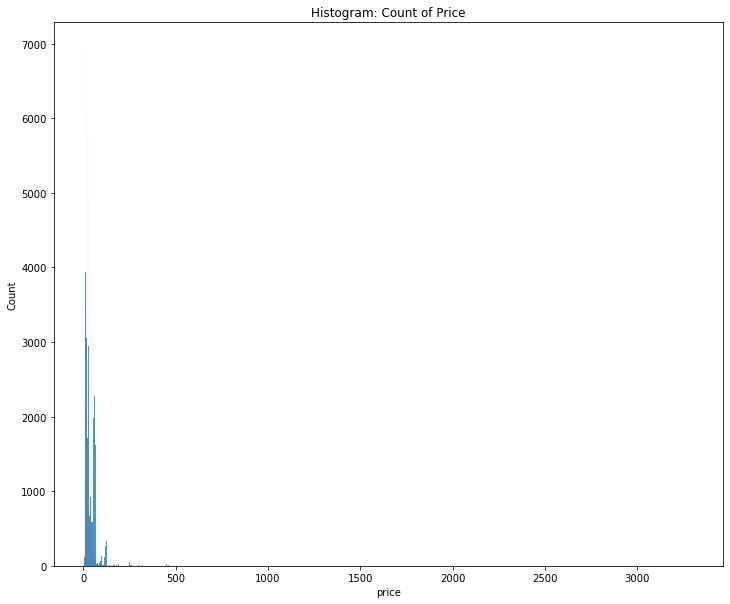

In [42]:
# Histogram of price distribution
sns.histplot(data['price']).set_title("Histogram: Count of Price")

In [43]:
# Statistics for the price column
data['price'].describe()

count    120975.000000
mean         35.363389
std          41.022218
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Count'>

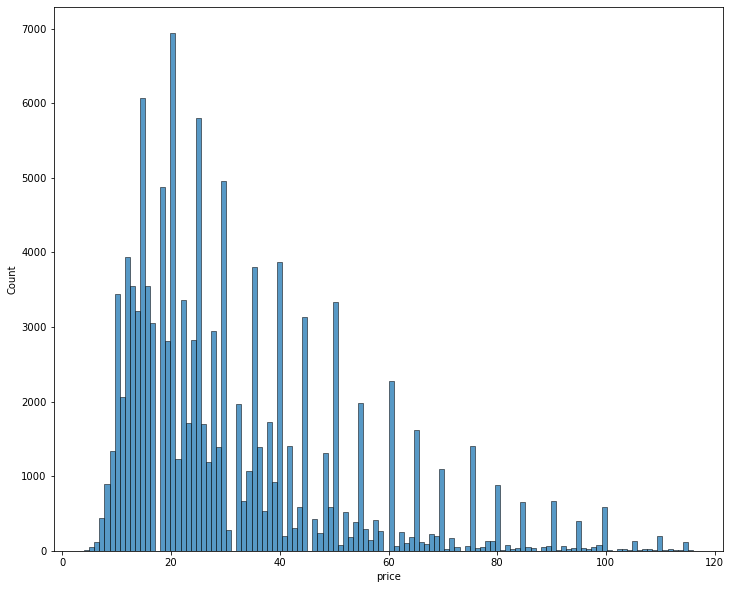

In [44]:
# Calculate first and third quartile
first_quartile = data['price'].describe()['25%']
third_quartile = data['price'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove exreme outliers
data_no_outliers = data[(data['price'] > (first_quartile - 3 * iqr)) & (data['price'] < (third_quartile + 3 * iqr))]

sns.histplot(data_no_outliers['price'])

Notes:
- The maximum value of a bottle of wine is far above the average
- Examples with outlying prices may have to be removed

## Data Cleaning

In [46]:
# Remove columns with more than 50% missing values
del data['region_2']

# Removing columns with more than 20% missing values that also wouldn't be available to the average wine shopper
del data['taster_twitter_handle']
del data['taster_name']

# Remove columns with too many unique values
del data['description']
del data['title']

# drop rows where price is null
data = data[data['price'].notnull()]

# Remove outlying price values
data = data[(data['price'] > (first_quartile - 3 * iqr)) & (data['price'] < (third_quartile + 3 * iqr))]

## Investigate Features

### 1. Feature: Points

Text(0.5, 1.0, 'Count of Points')

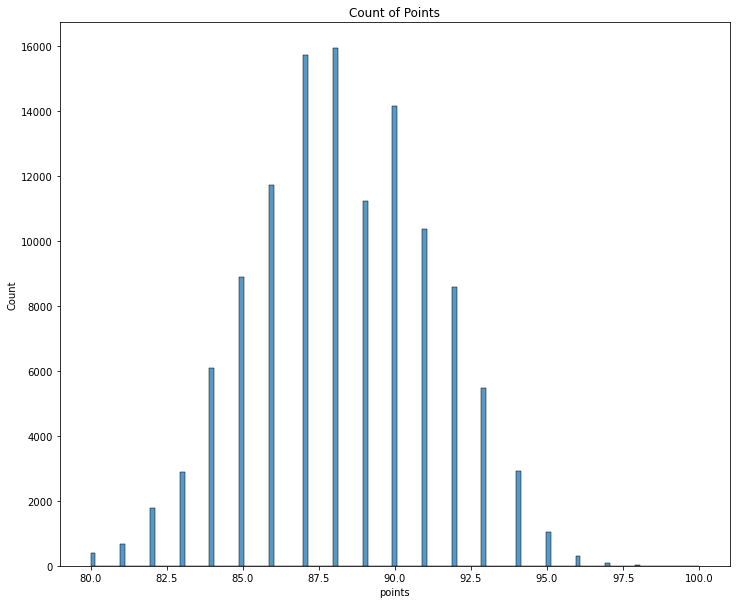

In [47]:
# Histogram of Wine Enthusiast Point values
sns.histplot(data['points']).set_title("Count of Points")

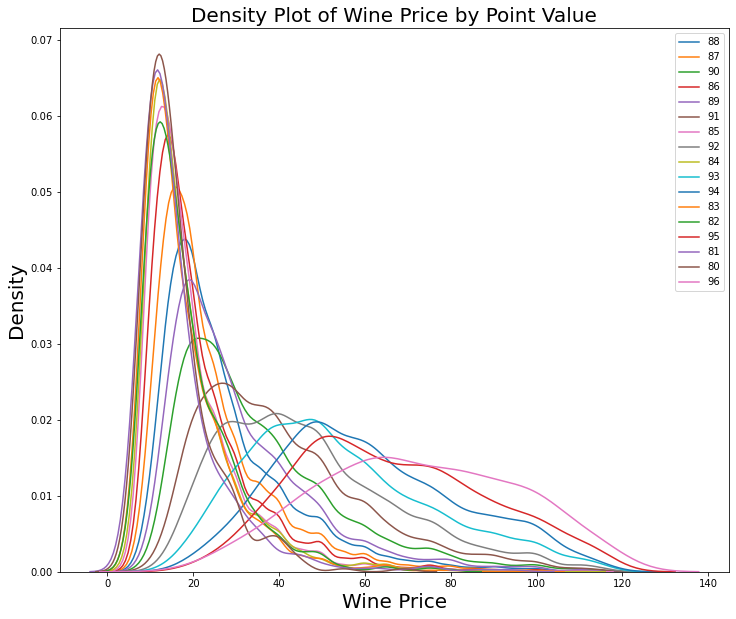

In [48]:
types = data['points'].value_counts(normalize=True)
types = list(types[types.values >= .001].index)

figsize(12, 10)

# Plot each point value
for point in types:
    # Select the point value
    subset = data[data['points'] == point]
    
    # Density plot of wine price
    sns.kdeplot(subset['price'],
               label = point, shade = False, alpha = 0.8);

    
# label the plot
plt.xlabel('Wine Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Wine Price by Point Value', size = 20);
plt.legend()

Notes:
* Point value does appear to show some correlation with price

### 2. Feature: Year (Vintage)

Text(0.5, 1.0, 'Count of Year')

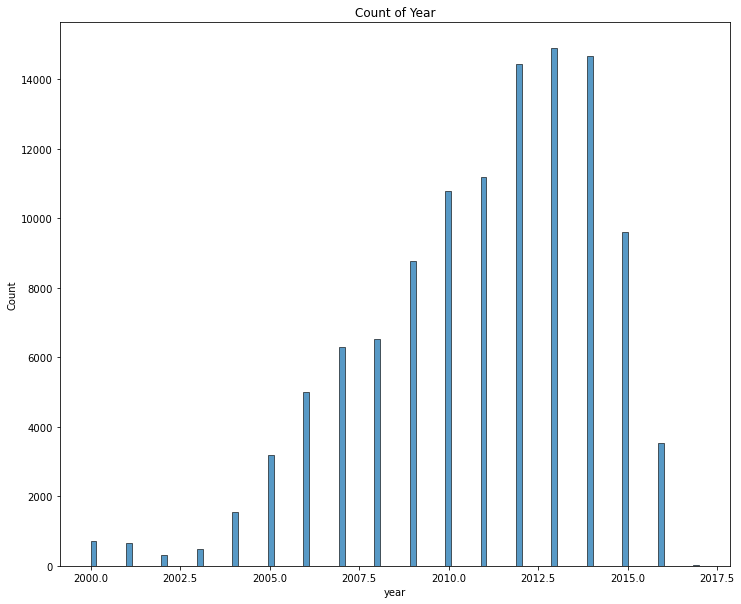

In [49]:
sns.histplot(data['year']).set_title("Count of Year")

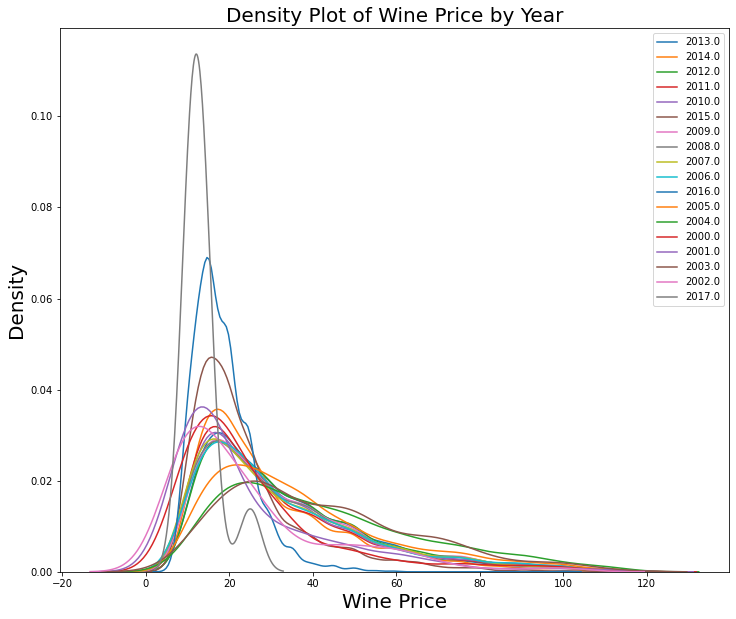

In [50]:
types = data['year'].value_counts(normalize=True)
types = list(types.index)

figsize(12, 10)

# Plot each point value
for year in types:
    # Select the point value
    subset = data[data['year'] == year]
    
    # Density plot of wine price
    sns.kdeplot(subset['price'],
               label = year, shade = False, alpha = 0.8);

    
# label the plot
plt.xlabel('Wine Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Wine Price by Year', size = 20);
plt.legend()

Notes:
- Counter-intuitively year (vintage) does not show a heavy correlation with price
- The data is also heavily skewed to the right

### 3. Feature: Country

In [58]:
# List the distribution of wines among the various countries
countries = list(data['country'].value_counts().index)
counts = list(data['country'].value_counts().values)
percents = list(data['country'].value_counts(normalize=True).values)

pd.DataFrame({'country': countries, 'count': counts, 'percent': percents})

,country,count,percent
0,US,53402,0.451683
1,France,16967,0.143510
2,Italy,16403,0.138739
3,Spain,6420,0.054301
4,Portugal,4818,0.040751
5,Chile,4382,0.037064
6,Argentina,3692,0.031228
7,Austria,2788,0.023581
8,Australia,2218,0.018760
9,Germany,2040,0.017255


In [59]:
# Show how many countries represent more than .1% of the examples
types = data['country'].value_counts(normalize=True)
types = list(types[types.values >= .001].index)
len(types)

18

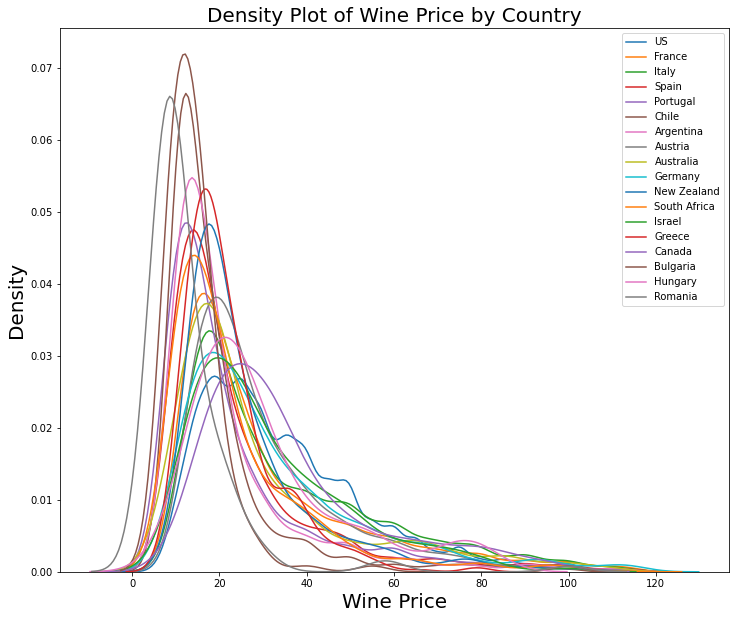

In [60]:
# Plot each country
for country in types:
    # Select the country
    subset = data[data['country'] == country]
    
    # Density plot of wine price
    sns.kdeplot(subset['price'],
               label = country, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Wine Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Wine Price by Country', size = 20);
plt.legend()

Notes:
- Country does not show a heavy correlation with price
- The wines are not distributed evenly among the various countries

### Feature: Variety (Grape)

In [61]:
# List the distribution of wines among the various grape varieties
varieties = list(data['variety'].value_counts().index)
counts = list(data['variety'].value_counts().values)
percents = list(data['variety'].value_counts(normalize=True).values)

pd.DataFrame({'variety': varieties, 'count': counts, 'percent': percents})[0:51]

,variety,count,percent
0,Pinot Noir,12483,0.105531
1,Chardonnay,10891,0.092073
2,Cabernet Sauvignon,8793,0.074336
3,Red Blend,8305,0.070211
4,Bordeaux-style Red Blend,5043,0.042634
5,Riesling,4894,0.041374
6,Sauvignon Blanc,4782,0.040427
7,Syrah,4025,0.034027
8,Rosé,3260,0.027560
9,Merlot,3026,0.025582


In [66]:
# Show how many varieties represent more than .5% of the examples
types = data['variety'].value_counts(normalize=True)
types = list(types[types.values >= .005].index)
len(types)

34

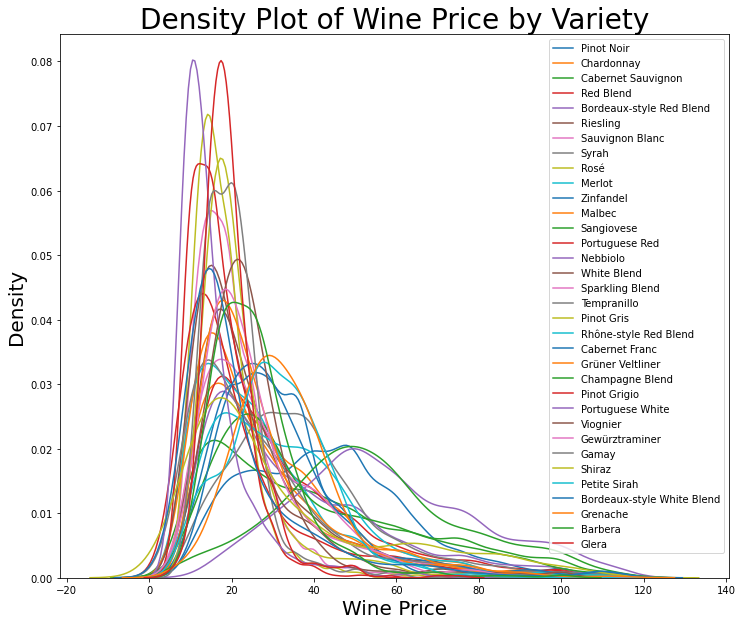

In [63]:
# Plot each variety
for variety in types:
    # Select the designation
    subset = data[data['variety'] == variety]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['price'],
               label = variety, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Wine Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Wine Price by Variety', size = 28);
plt.legend()

Notes
- Some varieties tend to skew more expensive, but the vast majority do not correlate significantly with price

## Feature: Region_1

In [64]:
# Show how many regions represent more than .1% of the examples
types = data['region_1'].value_counts(normalize=True)
types = list(types[types.values >= 0.001].index)
len(types)

180

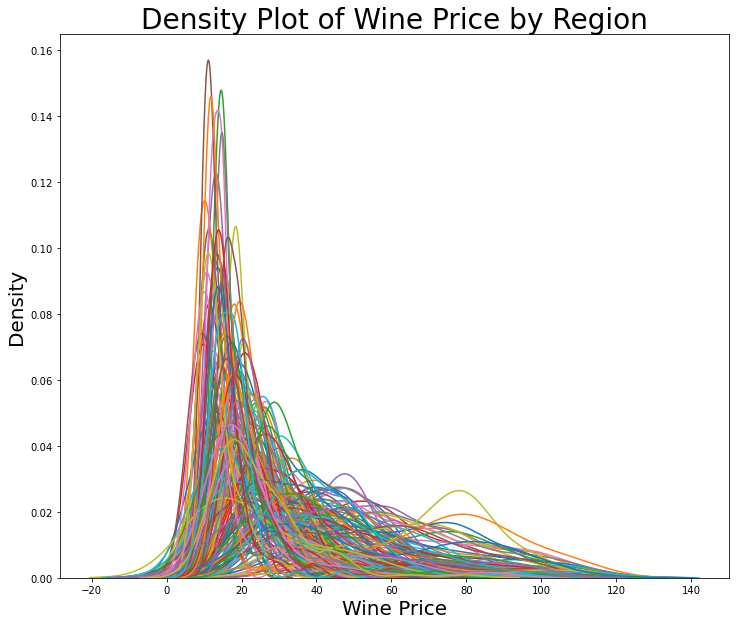

In [65]:
# Plot of distribution of price by region
figsize(12, 10)

# Plot each designation
for region in types:
    # Select the designation
    subset = data[data['region_1'] == region]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['price'],
               label = region, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Wine Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Wine Price by Region', size = 28);

In [73]:
# Show the number of unique regions per country
data.groupby('country')['region_1'].nunique()

country
Argentina                  31
Armenia                     0
Australia                  74
Austria                     0
Bosnia and Herzegovina      0
Brazil                      0
Bulgaria                    0
Canada                     12
Chile                       0
China                       0
Croatia                     0
Cyprus                      0
Czech Republic              0
England                     0
France                    350
Georgia                     0
Germany                     0
Greece                      0
Hungary                     0
India                       0
Israel                      0
Italy                     368
Lebanon                     0
Luxembourg                  0
Macedonia                   0
Mexico                      0
Moldova                     0
Morocco                     0
New Zealand                 0
Peru                        0
Portugal                    0
Romania                     0
Serbia                      0
Sl

Notes:
- Tough to tell correlation because provinces are so numerous
- Might make sense to limit region on a country by country basis, rather than across the whole dataset

## Feature: Province

In [68]:
# Show how many provinces represent more than .1% of the examples
types = data['province'].value_counts(normalize=True)
types = list(types[types.values >= 0.001].index)
len(types)

73

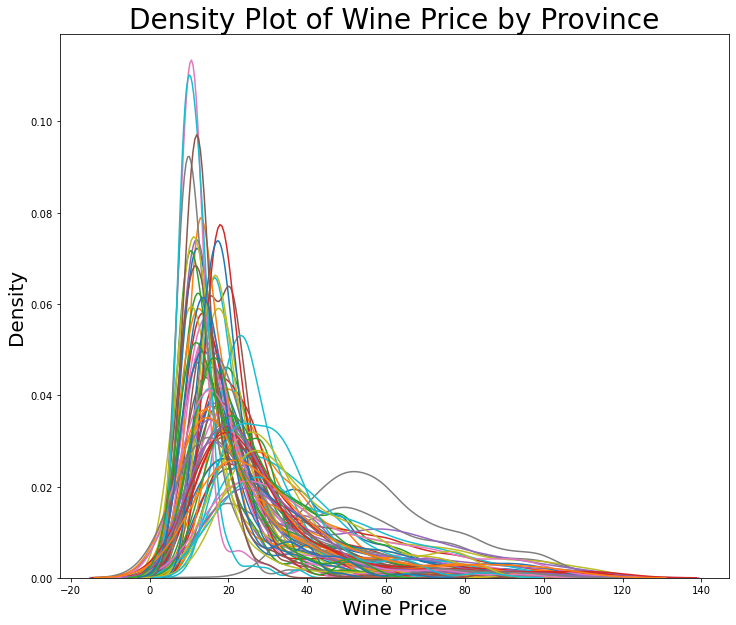

In [70]:
# Plot of distribution of price by region
figsize(12, 10)

# Plot each designation
for province in types:
    # Select the designation
    subset = data[data['province'] == province]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['price'],
               label = province, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Wine Price', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Wine Price by Province', size = 28);

Notes:
- Some regions demonstrate correlation with price